In [3]:
from Library_Kaggle_Atlas_Proteins import *
import keras

/home/ef2603jca2158/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
label_names

{0: 'Nucleoplasm',
 1: 'Nuclear membrane',
 2: 'Nucleoli',
 3: 'Nucleoli fibrillar center',
 4: 'Nuclear speckles',
 5: 'Nuclear bodies',
 6: 'Endoplasmic reticulum',
 7: 'Golgi apparatus',
 8: 'Peroxisomes',
 9: 'Endosomes',
 10: 'Lysosomes',
 11: 'Intermediate filaments',
 12: 'Actin filaments',
 13: 'Focal adhesion sites',
 14: 'Microtubules',
 15: 'Microtubule ends',
 16: 'Cytokinetic bridge',
 17: 'Mitotic spindle',
 18: 'Microtubule organizing center',
 19: 'Centrosome',
 20: 'Lipid droplets',
 21: 'Plasma membrane',
 22: 'Cell junctions',
 23: 'Mitochondria',
 24: 'Aggresome',
 25: 'Cytosol',
 26: 'Cytoplasmic bodies',
 27: 'Rods & rings'}

In [5]:
train_path = 'train/'
train_labels = pd.read_csv('./train.csv')
labels_path = './train.csv'
labels = train_labels

# Distribution of Labels: sorted by increasing frequency
-Finding the initial distribution of the targeted labels.

In [6]:
all_targets = train_labels['Target']

In [7]:
unique_targets = all_targets.unique()
unique_targets.shape[0]

582

In [8]:
target_counts=[]
for target in unique_targets:
    target_counts.append([target,np.sum(train_labels['Target']==target)])

In [9]:
target_counts = pd.DataFrame(target_counts, columns=["Labels", "count"])

In [10]:
sorted_target_counts = target_counts.sort_values(by = ["count"])

Text(0.5,1,'Unique Label Frequencies')

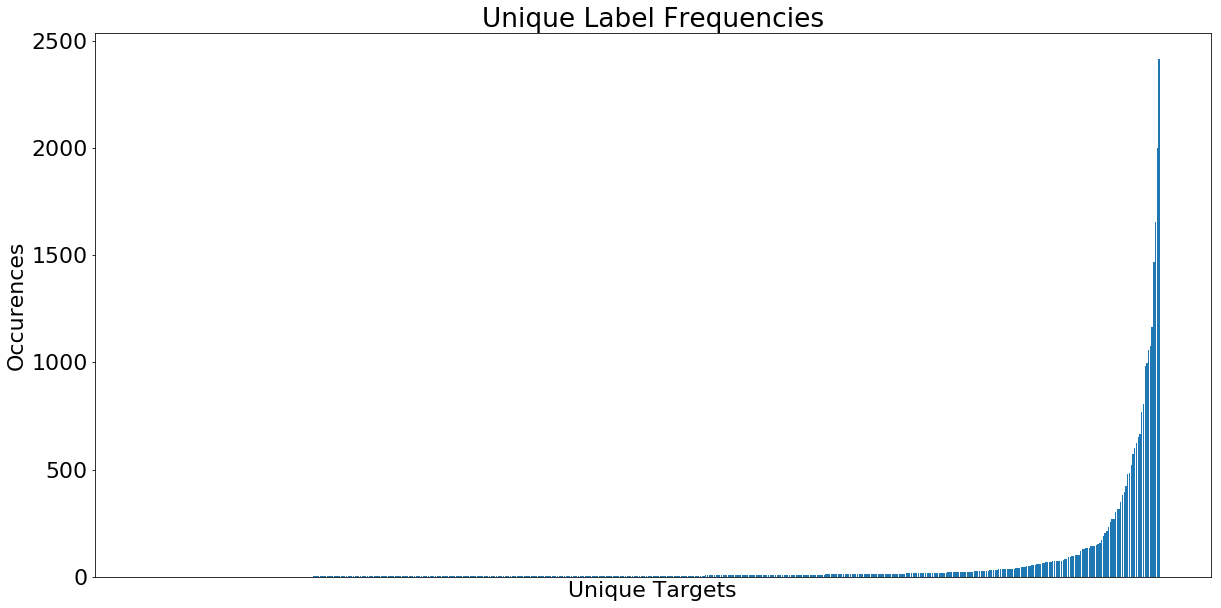

In [12]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.bar(sorted_target_counts["Labels"][:], sorted_target_counts["count"][:])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Occurences')
plt.xlabel('Unique Targets')
plt.title('Unique Label Frequencies')

# Above Graph Analysis
- It can be seen in the above graph that frequency of occurence for the given targets is extremely skewed to a small portion of the targets containing most of the occurences.
- A solution to this would be to take the less frequently occuring targets in the data set and generating more data for these targets. This will be done by taking the given occurences of these targets and generating augmented data by rotating and flipping said images.

#### Augment data for all targets that have less than 100 occurences

In [13]:
sorted_tuple_targets = zip(sorted_target_counts['Labels'],sorted_target_counts['count'])
targets_to_augment = [x[0] for x in sorted_tuple_targets if x[1] < 100]

In [14]:
len(targets_to_augment)

533

#### Augmenting 533/582 of the unique labels.

In [15]:
AllData = zip(train_labels['Id'],train_labels['Target'])
ids_to_augment = [x for x in AllData if ("".join(str(y) for y in x[1]) in targets_to_augment)]


In [16]:
len(ids_to_augment)

5808

In [17]:
under_represented_labels = list(map(lambda x: x[0], ids_to_augment))

#### 5808 Images top created augmented data for.

# -Data Augmentation Methods

In [14]:
def return_name(img):
    name=[]
    l=list(label_names.values())
    j=0
    for i in labels[img]:
        if i==1:
            name.append(l[j])
        j+=1
    return name

In [15]:
def make_image_row(image, subax, title, i ):
    subax[0].imshow(image[:,:,4*i], cmap="Greens")
    subax[1].imshow(image[:,:,4*i+1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[:,:,4*i+2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[:,:,4*i+3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

In [16]:
def rotate_image(image, angle, zoom):
   (h, w) = (512,512)
   center = (h//2, w//2)
   M = cv2.getRotationMatrix2D(center, angle, zoom)
   rotated = cv2.warpAffine(image, M, (w, h))
   return rotated

In [17]:
def vertical_flip(image):
    returnImageSet = np.zeros(image.shape)
    for i in range(len(image[0][0])):
        returnImageSet[:,:,i] = vertical_flip_single_image(image[:,:,i])
    return returnImageSet
    
    
    
def vertical_flip_single_image(singe_image):
    returnImage = np.zeros([len(singe_image),len(singe_image[0])])#[[0 for i in range(len(image))] for j in range(len(image[0]))]
    for x in range(len(singe_image)):
        for y in range(len(singe_image[x])):
            returnImage[(len(singe_image)-1)-x][y] = singe_image[x][y]
    return returnImage

def horizontal_flip(image):
    returnImageSet = np.zeros(image.shape)
    for i in range(len(image[0][0])):
        returnImageSet[:,:,i] = horizontal_flip_single_image(image[:,:,i])
    return returnImageSet
    
    
    
def horizontal_flip_single_image(singe_image):
    returnImage = np.zeros([len(singe_image),len(singe_image[0])])#[[0 for i in range(len(image))] for j in range(len(image[0]))]
    for x in range(len(singe_image)):
        for y in range(len(singe_image[x])):
            returnImage[x][(len(singe_image)-1)-y] = singe_image[x][y]
    return returnImage

### Illustration of the 11 data augmentations that're being generated.
- The original image is rotated 3 times, then it is flipped horizontall and rotated 3 times, and then flipped vertically and rotated 3 times. For a total of 11 newly generated images for each image.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff68c6ab2e8>,
      dtype=object)

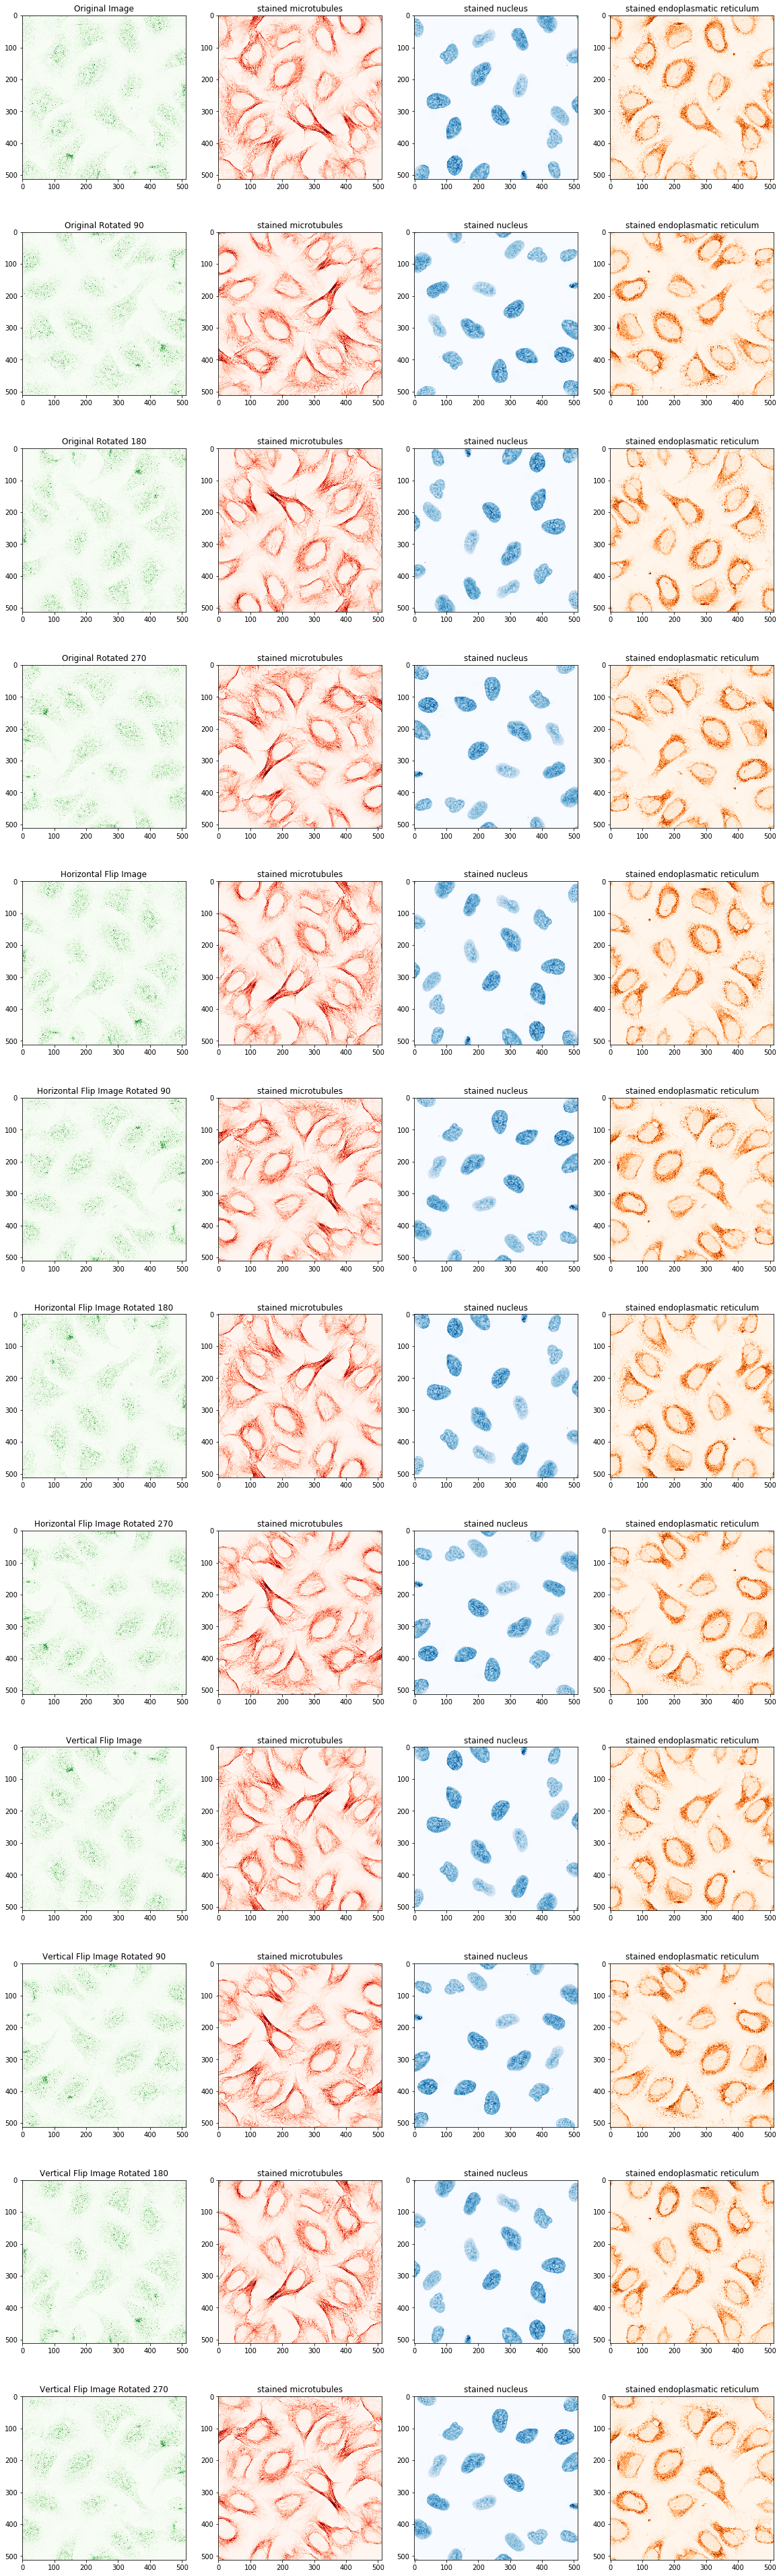

In [22]:
fig, ax = plt.subplots(12,4,figsize=(20,70))
filters=0


#for label in labels:
label = under_represented_labels[2]
image = load_image(train_path, label)
    
make_image_row(image, ax[0], "Original Image", filters)
make_image_row(rotate_image(image,90,1), ax[1], "Original Rotated 90", filters)
make_image_row(rotate_image(image,180,1), ax[2], "Original Rotated 180", filters)  
make_image_row(rotate_image(image,270,1), ax[3], "Original Rotated 270", filters)
horizontally_flippped_image = horizontal_flip(image)

make_image_row(horizontally_flippped_image, ax[4], "Horizontal Flip Image", filters)
make_image_row(rotate_image(horizontally_flippped_image,90,1), ax[5], "Horizontal Flip Image Rotated 90", filters)
make_image_row(rotate_image(horizontally_flippped_image,180,1), ax[6], "Horizontal Flip Image Rotated 180", filters)  
make_image_row(rotate_image(horizontally_flippped_image,270,1), ax[7], "Horizontal Flip Image Rotated 270", filters)


vertically_flippped_image = vertical_flip(image)
make_image_row(vertically_flippped_image, ax[8], "Vertical Flip Image", filters)
make_image_row(rotate_image(vertically_flippped_image,90,1), ax[9], "Vertical Flip Image Rotated 90", filters)
make_image_row(rotate_image(vertically_flippped_image,180,1), ax[10], "Vertical Flip Image Rotated 180", filters)  
make_image_row(rotate_image(vertically_flippped_image,270,1), ax[11], "Vertical Flip Image Rotated 270", filters)
#make_image_row(flip_image(image[:,:,0],"e"), ax[4], "working", filters)

In [23]:
import cv2
import numpy as np
import csv

def save_image_set(images, basepath, image_id):
    
    cv2.imwrite(basepath + "/" + image_id + "_green" + ".png", image[:,:,0])
    cv2.imwrite(basepath + "/" + image_id + "_red" + ".png", image[:,:,1])
    cv2.imwrite(basepath + "/" + image_id + "_blue" + ".png", image[:,:,2])
    cv2.imwrite(basepath + "/" + image_id + "_yellow" + ".png", image[:,:,3])

def generate_additional_training_CSV(labels):
    
    with open('Additional_Train.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['Id', 'Target'])
        for label in labels:
            target = get_target(label)
            filewriter.writerow([label + "_R90", target])
            filewriter.writerow([label + "_R180", target])
            filewriter.writerow([label + "_R270", target])
            filewriter.writerow([label + "_HF", target])
            filewriter.writerow([label + "_R90_HF", target])
            filewriter.writerow([label + "_R180_HF", target])
            filewriter.writerow([label + "_R270_HF", target])
            filewriter.writerow([label + "_VF", target])
            filewriter.writerow([label + "_R90_VF", target])
            filewriter.writerow([label + "_R180_VF", target])
            filewriter.writerow([label + "_R270_VF", target])


def generate_additional_images(labels):
    i = 0
    for label in labels:
        print(i)
        i += 1
        Original_Image = load_image(train_path, label)
        Original_Rotated_90 = rotate_image(Original_Image,90,1)
        Original_Rotated_180 = rotate_image(Original_Image,180,1)
        Original_Rotated_270 = rotate_image(Original_Image,270,1)
        
        save_image_set(Original_Rotated_90, "Additional_Training_Images", label + "_R90")
        save_image_set(Original_Rotated_180, "Additional_Training_Images", label + "_R180")
        save_image_set(Original_Rotated_270, "Additional_Training_Images", label + "_R270")
        
    
        Horizontal_Image = horizontal_flip(Original_Image)
        Horizontal_Rotated_90 = rotate_image(horizontally_flippped_image,90,1)
        Horizontal_Rotated_180 = rotate_image(horizontally_flippped_image,180,1)
        Horizontal_Rotated_270 = rotate_image(horizontally_flippped_image,270,1)
        
        save_image_set(Horizontal_Image, "Additional_Training_Images", label + "_HF")
        save_image_set(Horizontal_Rotated_90, "Additional_Training_Images", label + "_R90_HF")
        save_image_set(Horizontal_Rotated_180, "Additional_Training_Images", label + "_R180_HF")
        save_image_set(Horizontal_Rotated_270, "Additional_Training_Images", label + "_R270_HF")
    
    
        Vertical_Image = vertical_flip(Original_Image)
        Vertical_Rotated_90 = rotate_image(Vertical_Image,90,1)
        Vertical_Rotated_180 = rotate_image(Vertical_Image,180,1)
        Vertical_Rotated_270 = rotate_image(Vertical_Image,270,1)
        
        save_image_set(Vertical_Image, "Additional_Training_Images", label + "_VF")
        save_image_set(Vertical_Rotated_90, "Additional_Training_Images", label + "_R90_VF")
        save_image_set(Vertical_Rotated_180, "Additional_Training_Images", label + "_R180_VF")
        save_image_set(Vertical_Rotated_270, "Additional_Training_Images", label + "_R270_VF")

In [ ]:
#Generating the .csv mapping the labeled images to their given targets.
generate_additional_training_CSV(underRepresentedLabels)

#Generating the 11 additional augmented images for each given label.
generate_additional_images(underRepresentedLabels)

# Analyzing training data with augmented images

In [18]:
augmented_train_labels = pd.read_csv('Additional_Train.csv')

In [19]:
len(augmented_train_labels)

63888

#### Generated an additional 63888 samples for the underrepresented targets. For a total of 255,552 additional images created.

In [20]:
frames = [augmented_train_labels,train_labels]
new_train_labels = pd.concat(frames)

In [21]:
len(new_train_labels)

94960

In [22]:
new_target_counts=[]
for target in unique_targets:
    new_target_counts.append([target,np.sum(new_train_labels['Target']==target)])

In [23]:
new_target_counts_df = pd.DataFrame(new_target_counts, columns=["Labels", "count"])

In [24]:
new_sorted_target_counts = new_target_counts_df.sort_values(by = ["count"])

Text(0.5,1,'Unique Label Frequencies')

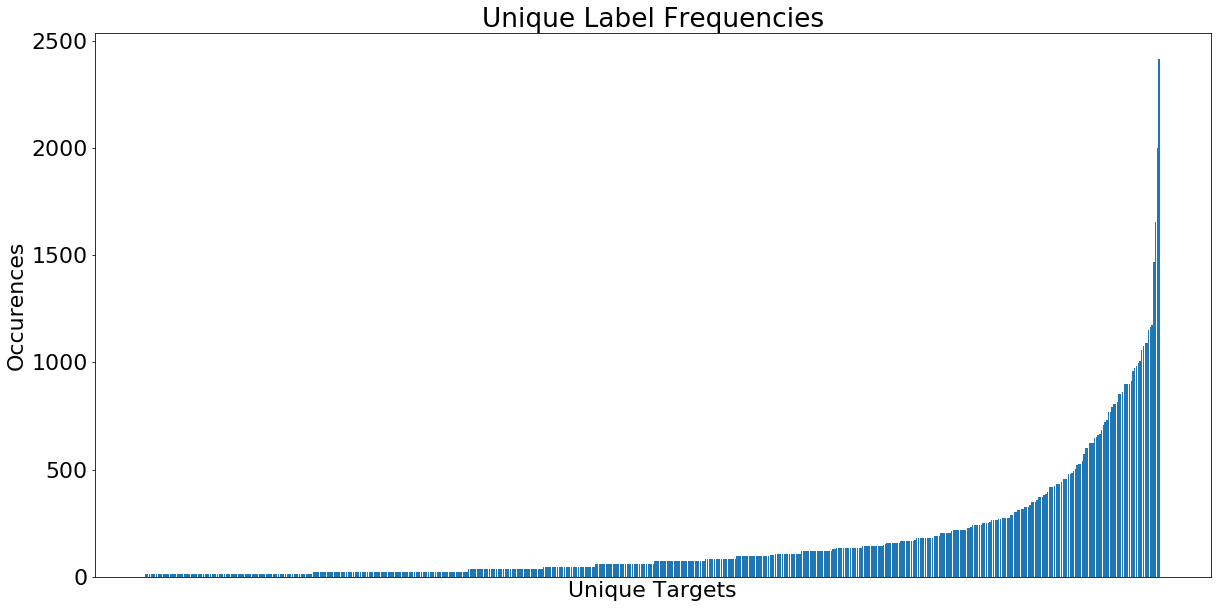

In [26]:
plt.figure(figsize=(20,10))
plt.bar(new_sorted_target_counts["Labels"][:], new_sorted_target_counts["count"][:])
plt.ylabel('Occurences')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel('Unique Targets')
plt.title('Unique Label Frequencies')

# Analysis:
- It's very clear that increasing the data 3x with the augmented data for the underrepresented targets that the distribution of data has grealy improved. The steep drop off in frequency of a given target has become a much smoother curve and the middle distribution of data is much better represented.

# Diving Deeper:
 - An interesting analysis would now be to look at how the frequency of an individual component of the target set.

In [29]:
def get_component_freq(train_labels):
    l = train_labels["Labels"].values
    freq = train_labels["count"].values
    l = [[int(i) for i in s.split(" ")] for s in l]
    labels = []
    for i in l:
        L = [0]*28
        for j in i:
            L[j]=1
        labels.append(L)
    all_counts = np.array(labels) * freq[:,np.newaxis]
    counts = [[0,0]]*len(all_counts[0])
    for x in range(len(all_counts[0])):
        summed = sum(all_counts[:,x])
        counts[x] = (x,summed)
    return counts

In [30]:
original_component_freq = get_component_freq(sorted_target_counts)
new_component_freq = get_component_freq(new_sorted_target_counts)

### Original Component Distribution

In [31]:
sorted_original_component_freq = sorted(original_component_freq, key=lambda tup: tup[1])
sorted_new_component_freq = sorted(new_component_freq, key=lambda tup: tup[1])

In [33]:
sorted_original_component_freq

[(27, 11),
 (15, 21),
 (10, 28),
 (9, 45),
 (8, 53),
 (20, 172),
 (17, 210),
 (24, 322),
 (26, 328),
 (16, 530),
 (13, 537),
 (12, 688),
 (22, 802),
 (18, 902),
 (6, 1008),
 (14, 1066),
 (11, 1093),
 (1, 1254),
 (19, 1482),
 (3, 1561),
 (4, 1858),
 (5, 2513),
 (7, 2822),
 (23, 2965),
 (2, 3621),
 (21, 3777),
 (25, 8228),
 (0, 12885)]

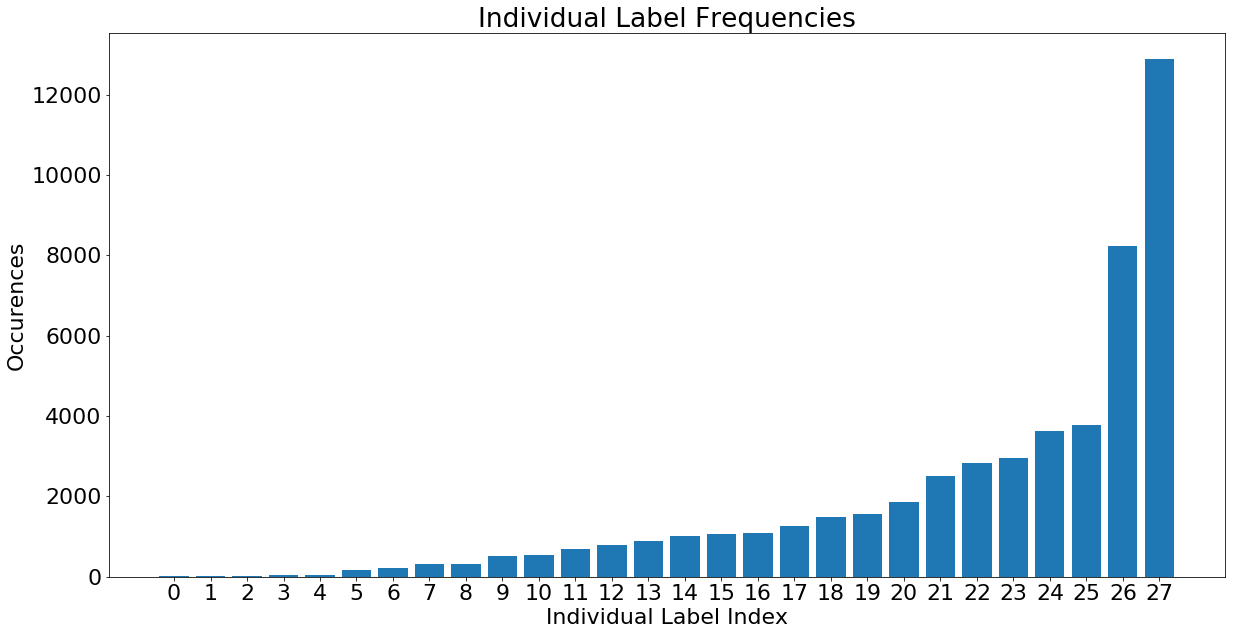

In [53]:


plt.figure(figsize=(20,10))
plt.xticks(list(map(lambda x: x[0], sorted_original_component_freq)))
plt.bar(range(len(sorted_original_component_freq)), list(map(lambda x: x[1], sorted_original_component_freq)))
plt.xticks(list(map(lambda x: x[0], sorted_original_component_freq)))
plt.ylabel('Occurences')
plt.xlabel('Individual Label Index')
plt.title('Individual Label Frequencies')
plt.show()

### New Component Distribution

Text(0.5,1,'Individual Label Frequencies With Augmented Data')

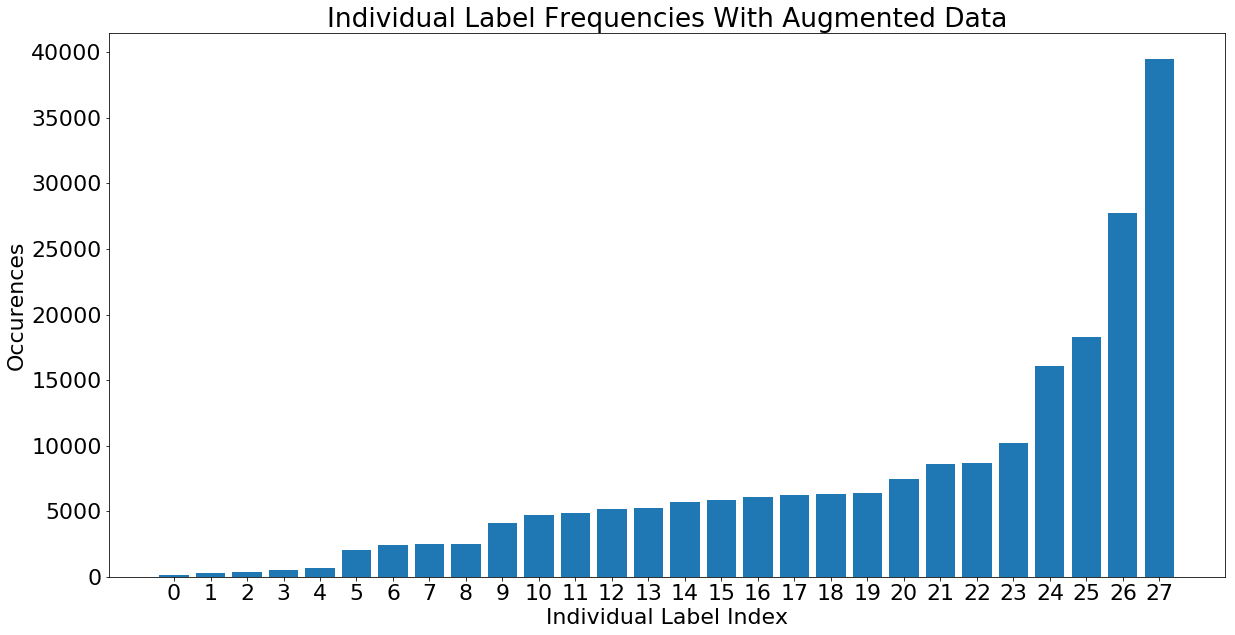

In [54]:
plt.figure(figsize=(20,10))
plt.xticks(list(map(lambda x: x[0], sorted_new_component_freq)))
x = plt.bar(range(len(new_component_freq)), list(map(lambda x: x[1], sorted_new_component_freq)))
plt.ylabel('Occurences')
plt.xlabel('Individual Label Index')
plt.title('Individual Label Frequencies With Augmented Data')

### Together

Text(0.5,1,'Single Component Frequencies')

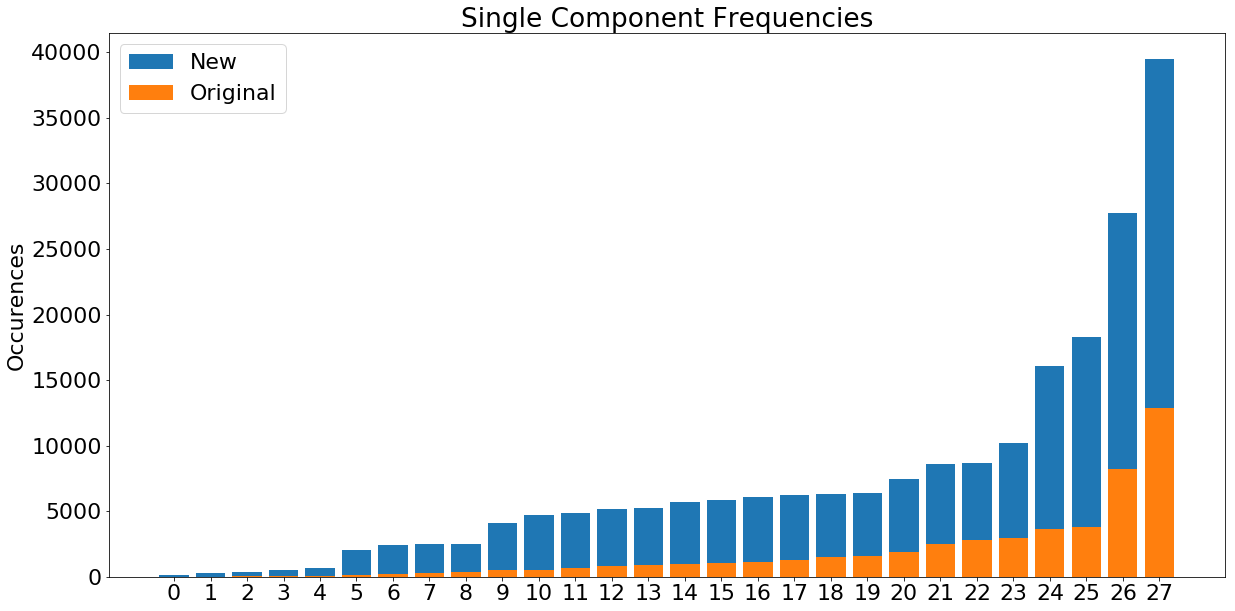

In [55]:
plt.figure(figsize=(20,10))
plt.xticks(list(map(lambda x: x[0], sorted_new_component_freq)))
x = plt.bar(range(len(new_component_freq)), list(map(lambda x: x[1], sorted_new_component_freq)))
y = plt.bar(range(len(sorted_original_component_freq)), list(map(lambda x: x[1], sorted_original_component_freq)))
plt.legend((x[0], y[0]), ('New', 'Original'))
plt.ylabel('Occurences')
plt.title('Single Component Frequencies')

In [42]:
xx = list(map(lambda x: x[0], sorted_original_component_freq))

In [43]:
xx

[27,
 15,
 10,
 9,
 8,
 20,
 17,
 24,
 26,
 16,
 13,
 12,
 22,
 18,
 6,
 14,
 11,
 1,
 19,
 3,
 4,
 5,
 7,
 23,
 2,
 21,
 25,
 0]